In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
2786,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
12895,/home/pascal_steiger/Downloads/data/FIN/img_FI...,FIN
15762,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
24246,/home/pascal_steiger/Downloads/data/CHE/img_47...,CHE
127,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
4810,/home/pascal_steiger/Downloads/data/ITA/img_IT...,ITA
22071,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
9938,/home/pascal_steiger/Downloads/data/LTU/img_LT...,LTU
1898,/home/pascal_steiger/Downloads/data/HRV/img_HR...,HRV
22247,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
23790  /home/pascal_steiger/Downloads/data/CHE/img_47...   CHE
22919  /home/pascal_steiger/Downloads/data/NLD/img_51...   NLD
11770  /home/pascal_steiger/Downloads/data/SVN/img_SV...   SVN
18194  /home/pascal_steiger/Downloads/data/SVK/img_SV...   SVK
18820  /home/pascal_steiger/Downloads/data/BEL/img_50...   BEL
(21234, 2)
                                                    path label
25527  /home/pascal_steiger/Downloads/data/DNK/img_DN...   DNK
21916  /home/pascal_steiger/Downloads/data/CZE/img_CZ...   CZE
5857   /home/pascal_steiger/Downloads/data/HUN/img_HU...   HUN
2752   /home/pascal_steiger/Downloads/data/ISL/img_IS...   ISL
25474  /home/pascal_steiger/Downloads/data/DNK/img_DN...   DNK
(5309, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(224, 224),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [8]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
tl_resnet = ResNet50V2(include_top=True,weights="imagenet")
for layer in tl_resnet.layers:
    layer.trainable = False

for layer in tl_resnet.layers[-26:]:
    layer.trainable = True 
print(tl_resnet.summary())

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [18]:
tl_resnet.layers.pop()
tl_resnet.layers.pop()
tl_resnet.layers.pop()


I = Input(shape=(224, 224, 3))



x = tl_resnet(I)

flat= Flatten()(x)


dense = Dense(4096, activation='relu', name='denserelu')(flat)

dense2 = Dense(2048, activation='relu', name='denserelu2')(dense)

dense3 = Dense(26, activation='softmax', name='my_dense')(dense2)

#prediction = Dense(26, activation='softmax', name='prediction')



#out2 = prediction(x)


new_model2 = tf.keras.Model(I, dense3)

new_model2.summary()





Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1000)              25613800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
denserelu (Dense)            (None, 4096)              4100096   
_________________________________________________________________
denserelu2 (Dense)           (None, 2048)              8390656   
_________________________________________________________________
my_dense (Dense)             (None, 26)                53274     
Total params: 38,157,826
Trainable params: 23,526,402
Non-trainable params: 14,631,424
________________________________________

In [19]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [23]:
new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:0"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_model_v4.h5')

Epoch 1/200
664/664 [==============================] - 350s 523ms/step - loss: 1.4450 - sparse_categorical_accuracy: 0.5311 - val_loss: 2.1869 - val_sparse_categorical_accuracy: 0.3871
Epoch 2/200
664/664 [==============================] - 343s 517ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.5443 - val_loss: 2.1864 - val_sparse_categorical_accuracy: 0.3971
Epoch 3/200
664/664 [==============================] - 340s 512ms/step - loss: 1.3555 - sparse_categorical_accuracy: 0.5582 - val_loss: 2.2207 - val_sparse_categorical_accuracy: 0.3963
Epoch 4/200
664/664 [==============================] - 349s 526ms/step - loss: 1.2988 - sparse_categorical_accuracy: 0.5759 - val_loss: 2.1854 - val_sparse_categorical_accuracy: 0.4086
Epoch 5/200
664/664 [==============================] - 362s 544ms/step - loss: 1.2625 - sparse_categorical_accuracy: 0.5860 - val_loss: 2.1951 - val_sparse_categorical_accuracy: 0.4006
Epoch 6/200
664/664 [==============================] - 343s 516ms/step - lo

Epoch 45/200
664/664 [==============================] - 348s 525ms/step - loss: 0.2009 - sparse_categorical_accuracy: 0.9343 - val_loss: 3.2903 - val_sparse_categorical_accuracy: 0.4492
Epoch 46/200
664/664 [==============================] - 345s 519ms/step - loss: 0.1937 - sparse_categorical_accuracy: 0.9389 - val_loss: 3.3701 - val_sparse_categorical_accuracy: 0.4526
Epoch 47/200
664/664 [==============================] - 343s 517ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9328 - val_loss: 3.2106 - val_sparse_categorical_accuracy: 0.4549

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 48/200
664/664 [==============================] - 347s 523ms/step - loss: 0.1597 - sparse_categorical_accuracy: 0.9494 - val_loss: 3.3290 - val_sparse_categorical_accuracy: 0.4607
Epoch 49/200
664/664 [==============================] - 361s 544ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9552 - val_loss: 3.4937 - val_sparse_categorical_accura

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


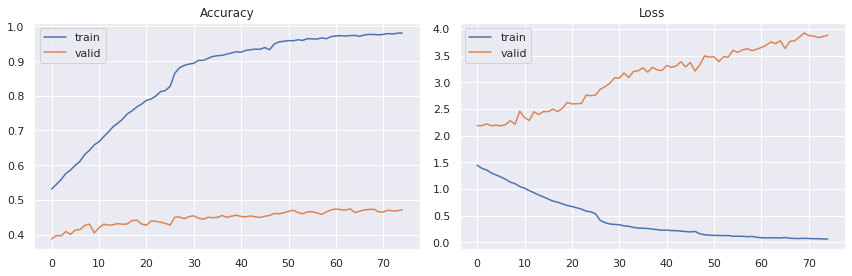

In [24]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(224,224)-TL_v4.png')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/mnt/data/testing3/",
        target_size=(224, 224),
        batch_size=1,
        class_mode='sparse',
        shuffle=False)

res=validmodel2.predict(test_generator, steps=len(test_generator), verbose=1)
y_classes = res.argmax(axis=-1)
print(labelStringArr)
label2 = np.sort(labelStringArr)
print(label2)
print(y_classes)

filenames=test_generator.filenames
label_map = (train_generator.class_indices)
print(label_map)
preds = []
labels = []
for i in range(len(filenames)):
    #print(res[i])
    preds.append(res[i][np.argmax(res[i])])
    labels.append(label2[y_classes[i]])




# Data frame
results=pd.DataFrame({"file":filenames, "class":labels, "pr":preds})

results.to_csv("res2.csv", index = False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = validmodel2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = label2
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))